In [ ]:
# Update variable name from `mock_data` to `full_data`
# This assumes the original code from the user is being updated

import pandas as pd
import ast

# Load data generated from ScispaCy pipeline
data_path = "labeled_notes_with_symptoms.csv"
full_data = pd.read_csv(data_path)

# Convert stringified lists back into Python lists
full_data["SYMPTOMS"] = full_data["SYMPTOMS"].apply(ast.literal_eval)

# Show preview
print("Data loaded:")
print(full_data[["SYMPTOMS", "ICD9_CODE"]].head())

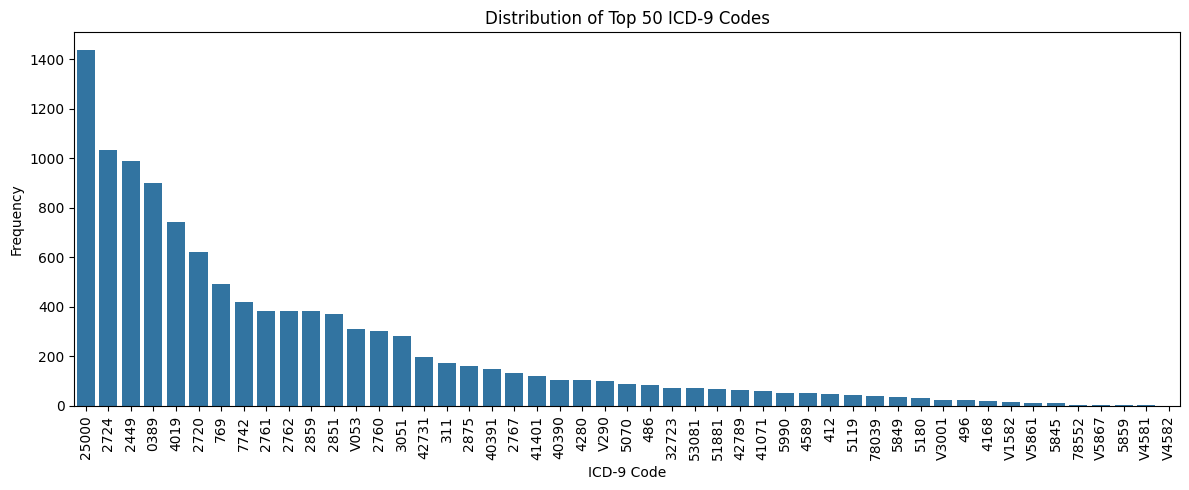

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize label distribution
label_counts = full_data["ICD9_CODE"].value_counts()

plt.figure(figsize=(12, 5))
sns.barplot(x=label_counts.index[:50], y=label_counts.values[:50])
plt.title("Distribution of Top 50 ICD-9 Codes")
plt.xlabel("ICD-9 Code")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [3]:
# Inspect column names and types
print("Column names:", full_data.columns.tolist())
print("\nData types:")
print(full_data.dtypes)

# Check how many rows have at least one symptom
non_empty_symptoms = full_data["SYMPTOMS"].apply(lambda x: len(x) > 0).sum()
print(f"\nRows with at least one symptom: {non_empty_symptoms} / {len(full_data)}")

Column names: ['HADM_ID', 'SYMPTOMS', 'ICD9_CODE']

Data types:
HADM_ID      float64
SYMPTOMS      object
ICD9_CODE     object
dtype: object

Rows with at least one symptom: 10619 / 11225


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TF-IDF Vectorization
corpus = full_data["SYMPTOMS"].apply(lambda x: ' '.join(x))
tfidf = TfidfVectorizer()
X_tfidf_scaled = tfidf.fit_transform(corpus).toarray()
print("TF-IDF shape:", X_tfidf_scaled.shape)

# Train Word2Vec on tokenized symptom lists
w2v_model = Word2Vec(sentences=full_data["SYMPTOMS"], vector_size=50, window=2, min_count=1, workers=4, seed=42)

# Average Word2Vec vector per patient admission
def avg_vector(symptoms, model, dim=50):
    vectors = [model.wv[word] for word in symptoms if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

X_w2v = np.array([avg_vector(sym, w2v_model) for sym in full_data["SYMPTOMS"]])
print("Word2Vec shape:", X_w2v.shape)

TF-IDF shape: (11225, 739)
Word2Vec shape: (11225, 50)


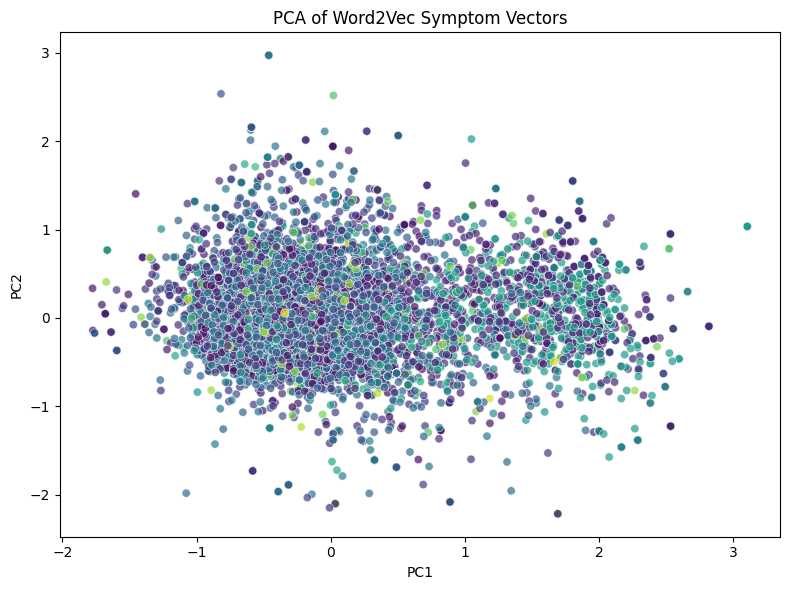

In [5]:
# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
reduced_w2v = pca.fit_transform(X_w2v)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_w2v[:, 0], y=reduced_w2v[:, 1], hue=full_data["ICD9_CODE"], palette="viridis", legend=False, alpha=0.7)
plt.title("PCA of Word2Vec Symptom Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


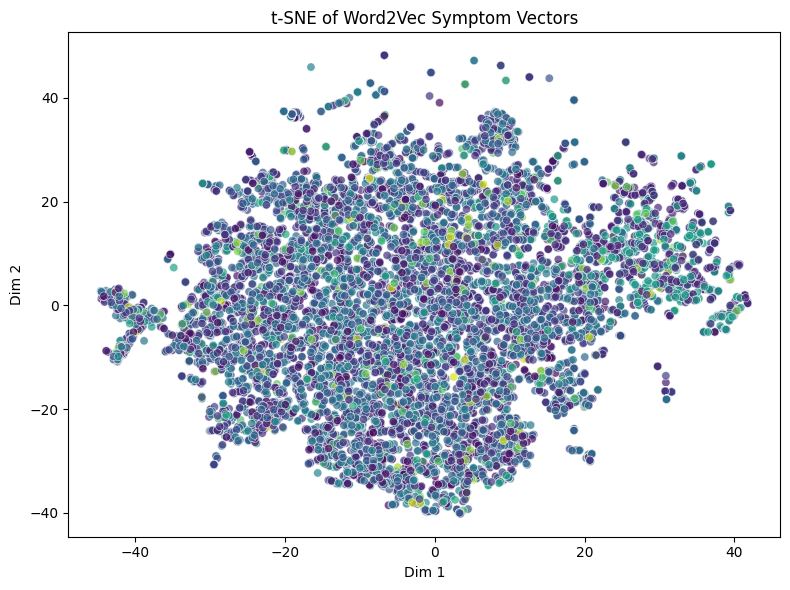

In [6]:
# Optional: t-SNE for deeper cluster visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
reduced_tsne = tsne.fit_transform(X_w2v)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1], hue=full_data["ICD9_CODE"], palette="viridis", legend=False, alpha=0.7)
plt.title("t-SNE of Word2Vec Symptom Vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

C:\Users\Allen\AppData\Local\Temp\ipykernel_10340\2673469567.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=encoded_labels, y=np.bincount(labels), palette="Blues_d")


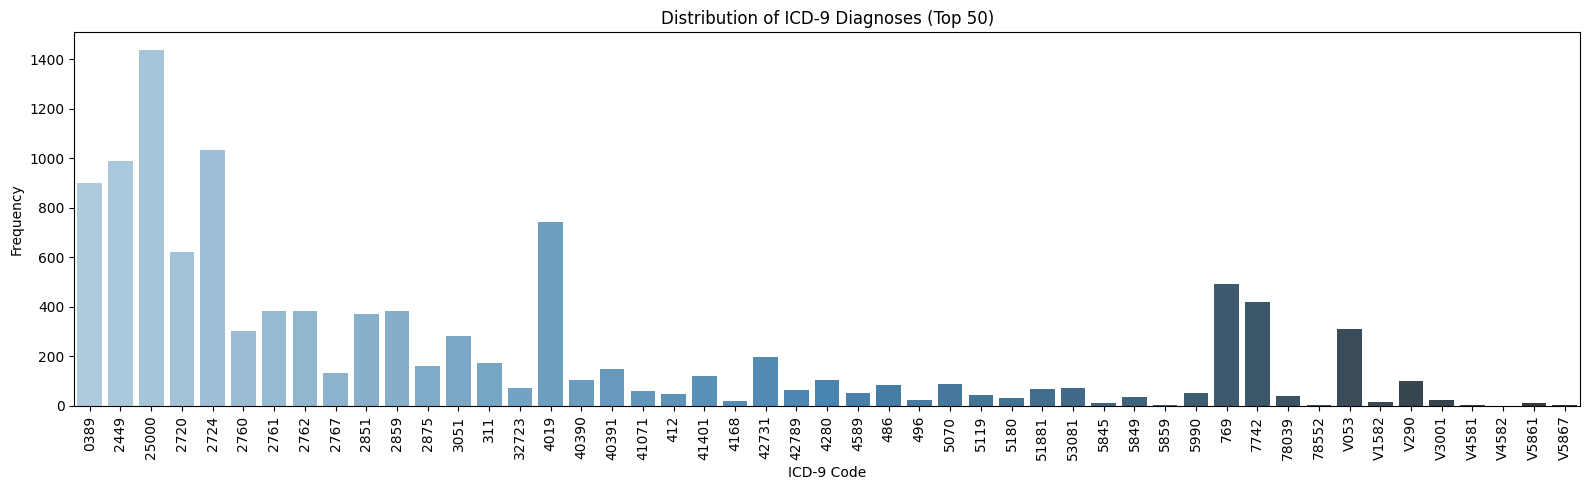

Ready for model input: torch.Size([10618, 55, 50]), 49 classes


In [8]:
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Step 1: Label encode ICD-9 codes
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(full_data["ICD9_CODE"])
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Step 2: Convert symptom sequences to Word2Vec embeddings
sequence_vectors = []
for symptoms in full_data["SYMPTOMS"]:
    vectors = [w2v_model.wv[word] for word in symptoms if word in w2v_model.wv]
    if vectors:
        sequence_vectors.append(torch.tensor(np.array(vectors), dtype=torch.float32))
    else:
        sequence_vectors.append(None)

# Step 3: Filter out empty sequences
valid_indices = [i for i, vec in enumerate(sequence_vectors) if vec is not None]
filtered_sequences = [sequence_vectors[i] for i in valid_indices]
filtered_labels = labels_tensor[valid_indices]

# Step 4: Remove classes with <2 instances
label_counts = Counter(filtered_labels.tolist())
valid_label_set = {label for label, count in label_counts.items() if count >= 2}

final_indices = [i for i, label in enumerate(filtered_labels) if label.item() in valid_label_set]
filtered_sequences = [filtered_sequences[i] for i in final_indices]
filtered_labels = filtered_labels[final_indices]

# Step 5: Pad sequences
padded_sequences = pad_sequence(filtered_sequences, batch_first=True)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, filtered_labels, test_size=0.3, stratify=filtered_labels, random_state=42
)

# Step 7: PyTorch DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# Step 8: Visualize class distribution
encoded_labels = label_encoder.transform(label_encoder.classes_)  # for plotting
label_names = label_encoder.classes_

plt.figure(figsize=(16, 5))
sns.barplot(x=encoded_labels, y=np.bincount(labels), palette="Blues_d")
plt.xticks(ticks=encoded_labels, labels=label_names, rotation=90)
plt.title("Distribution of ICD-9 Diagnoses (Top 50)")
plt.xlabel("ICD-9 Code")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Final confirmation
print(f"Ready for model input: {padded_sequences.shape}, {len(label_encoder.classes_)} classes")

In [9]:
import torch.nn as nn
import torch.optim as optim

# Step 1: Define BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional → hidden_dim * 2

    def forward(self, x):
        lstm_out, _ = self.lstm(x)                  # Shape: (batch, seq_len, hidden*2)
        out = self.fc(lstm_out[:, -1, :])           # Use final time step output
        return out

# Step 2: Initialize model
input_dim = padded_sequences.shape[2]              # 50 if using Word2Vec
hidden_dim = 64
output_dim = len(label_encoder.classes_)

model = BiLSTMClassifier(input_dim, hidden_dim, output_dim)

# Show model summary
print("Initialized BiLSTM model:")
print(model)

Initialized BiLSTM model:
BiLSTMClassifier(
  (lstm): LSTM(50, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=49, bias=True)
)


In [11]:
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

# Step 1: Ensure class weights match total number of output classes
num_classes = len(label_encoder.classes_)
all_classes = np.arange(num_classes)

# Use full label distribution for balanced weights (not just y_train)
weights = compute_class_weight(class_weight='balanced',
                                classes=all_classes,
                                y=labels_tensor.numpy())

class_weights = torch.tensor(weights, dtype=torch.float32)

# Step 2: Define loss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Training loop
epochs = 10
train_losses = []
train_accuracies = []

print("Starting training...\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

# Put model in eval mode
model.eval()

Starting training...



Epoch 1/10: 100%|██████████████████████████████████████████████████████| 233/233 [00:04<00:00, 48.62it/s]


Epoch 1 | Loss: 3.8719 | Accuracy: 0.0525


Epoch 2/10: 100%|██████████████████████████████████████████████████████| 233/233 [00:04<00:00, 49.59it/s]


Epoch 2 | Loss: 3.8578 | Accuracy: 0.0379


Epoch 3/10: 100%|██████████████████████████████████████████████████████| 233/233 [00:04<00:00, 50.25it/s]


Epoch 3 | Loss: 3.8486 | Accuracy: 0.0250


Epoch 4/10: 100%|██████████████████████████████████████████████████████| 233/233 [00:04<00:00, 49.83it/s]


Epoch 4 | Loss: 3.8441 | Accuracy: 0.0332


Epoch 5/10: 100%|██████████████████████████████████████████████████████| 233/233 [00:04<00:00, 50.01it/s]


Epoch 5 | Loss: 3.8459 | Accuracy: 0.0396


Epoch 6/10: 100%|██████████████████████████████████████████████████████| 233/233 [00:04<00:00, 50.15it/s]


Epoch 6 | Loss: 3.8427 | Accuracy: 0.0396


Epoch 7/10: 100%|██████████████████████████████████████████████████████| 233/233 [00:04<00:00, 50.25it/s]


Epoch 7 | Loss: 3.8440 | Accuracy: 0.0428


Epoch 8/10: 100%|██████████████████████████████████████████████████████| 233/233 [00:04<00:00, 50.26it/s]


Epoch 8 | Loss: 3.8409 | Accuracy: 0.0326


Epoch 9/10: 100%|██████████████████████████████████████████████████████| 233/233 [00:04<00:00, 49.45it/s]


Epoch 9 | Loss: 3.8421 | Accuracy: 0.0410


Epoch 10/10: 100%|█████████████████████████████████████████████████████| 233/233 [00:04<00:00, 48.65it/s]

Epoch 10 | Loss: 3.8304 | Accuracy: 0.0457


BiLSTMClassifier(
  (lstm): LSTM(50, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=49, bias=True)
)

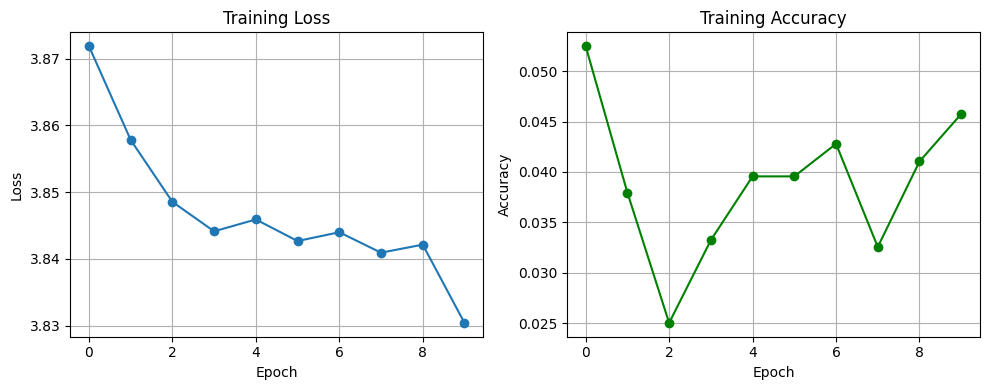

In [12]:
import matplotlib.pyplot as plt

# Plot training loss and accuracy
plt.figure(figsize=(10, 4))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

Accuracy: 0.0621
Micro F1: 0.0621
Macro F1: 0.0091
   precision  recall  f1-score  support
0        0.0     0.0       0.0    253.0
1        0.0     0.0       0.0    276.0
2        0.0     0.0       0.0    403.0
3        0.0     0.0       0.0    175.0
4        0.0     0.0       0.0    286.0


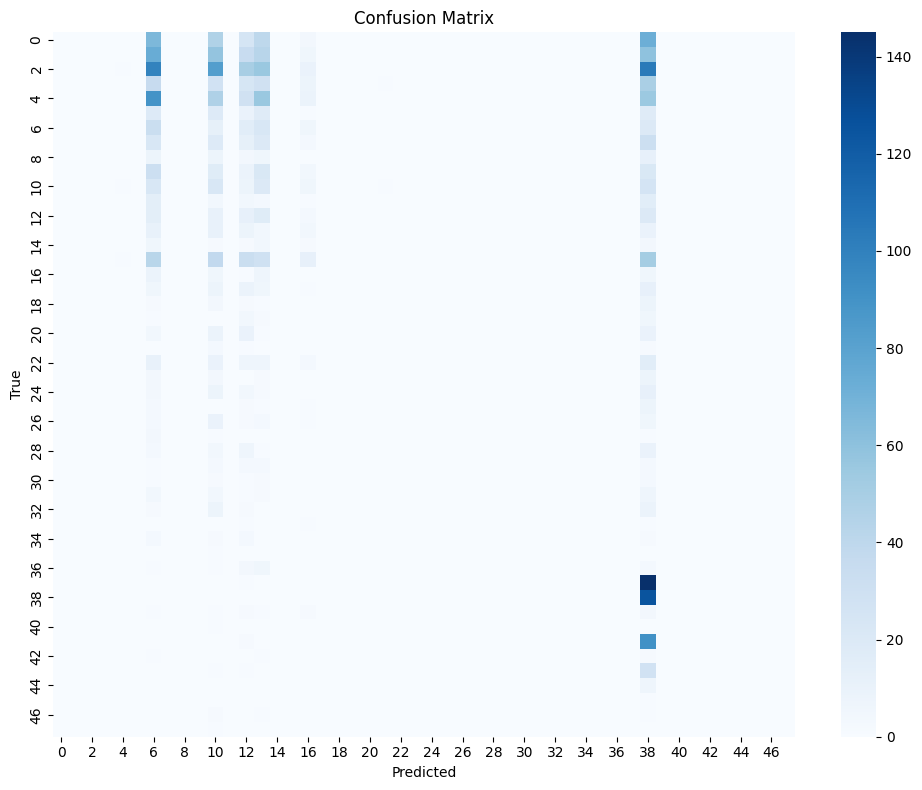

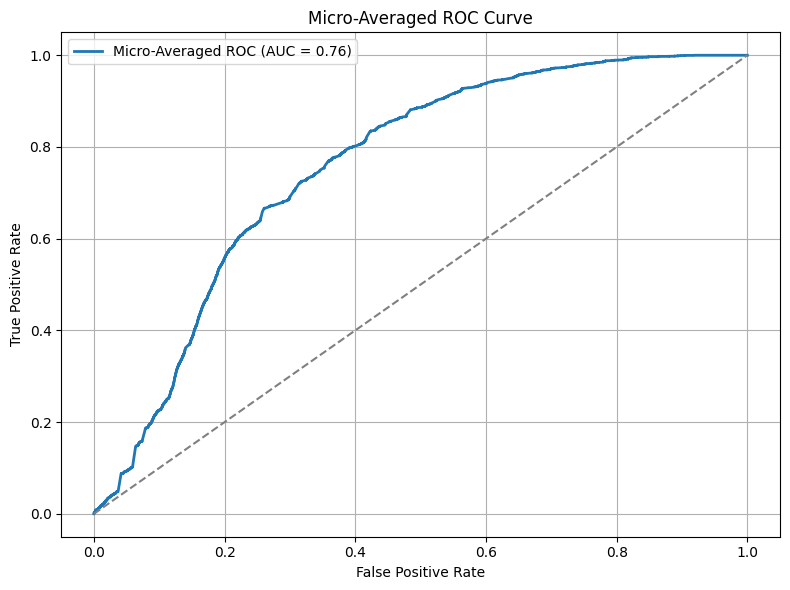

In [13]:

from sklearn.metrics import accuracy_score

# Predict using the trained model
y_pred = model.predict(X_test)

# If y_pred are probabilities, convert them to class labels
if hasattr(y_pred[0], "__len__") and not isinstance(y_pred[0], str):
    try:
        y_pred_labels = y_pred.argmax(axis=1)
    except:
        y_pred_labels = (y_pred > 0.5).astype(int)
else:
    y_pred_labels = y_pred

# Ensure y_test is also encoded if needed
print("Accuracy:", accuracy_score(y_test, y_pred_labels))


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np

# Step 1: Convert symptom lists to documents
corpus = full_data["SYMPTOMS"].apply(lambda x: ' '.join(x))

# Step 2: TF-IDF vectorization
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(corpus)

# Step 3: Normalize features
scaler = StandardScaler(with_mean=False)
X_tfidf_scaled = scaler.fit_transform(X_tfidf)

# Step 4: Vocab mapping
vocab = tfidf.vocabulary_
idf_weights = tfidf.idf_
vocab_inv = {v: k for k, v in vocab.items()}

# Step 5: Build sequences of TF-IDF token vectors
tfidf_sequences = []
for doc in X_tfidf_scaled:
    indices = doc.indices
    data = doc.data
    sequence = []
    for idx, val in zip(indices, data):
        vec = np.zeros(len(vocab))
        vec[idx] = val
        sequence.append(vec)
    tfidf_sequences.append(torch.tensor(sequence, dtype=torch.float32))

# Step 6: Reuse previous label encoder and filter valid sequences
labels_tensor = torch.tensor(label_encoder.transform(full_data["ICD9_CODE"]), dtype=torch.long)
valid_indices_tfidf = [i for i, seq in enumerate(tfidf_sequences) if len(seq) > 0]
tfidf_sequences = [tfidf_sequences[i] for i in valid_indices_tfidf]
labels_tfidf = labels_tensor[valid_indices_tfidf]

# Step 7: Filter out classes with <2 samples (for stratification)
_, counts = np.unique(labels_tfidf.numpy(), return_counts=True)
keep_classes = np.where(counts >= 2)[0]
filtered_indices = [i for i in range(len(labels_tfidf)) if labels_tfidf[i].item() in keep_classes]

tfidf_sequences = [tfidf_sequences[i] for i in filtered_indices]
labels_tfidf = labels_tfidf[filtered_indices]

# Step 8: Pad sequences
padded_tfidf = pad_sequence(tfidf_sequences, batch_first=True)

# Step 9: Stratified train/test split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    padded_tfidf, labels_tfidf, test_size=0.3, stratify=labels_tfidf, random_state=42
)

# Step 10: Wrap in DataLoaders
train_loader_tfidf = DataLoader(TensorDataset(X_train_tfidf, y_train_tfidf), batch_size=32, shuffle=True)
test_loader_tfidf = DataLoader(TensorDataset(X_test_tfidf, y_test_tfidf), batch_size=32)

print(f" TF-IDF padded shape: {padded_tfidf.shape}, Remaining classes: {len(torch.unique(labels_tfidf))}")

 TF-IDF padded shape: torch.Size([10618, 79, 739]), Remaining classes: 48


In [16]:
# Initialize model for TF-IDF vectors
input_dim_tfidf = padded_tfidf.shape[2]
model_tfidf = BiLSTMClassifier(input_dim=input_dim_tfidf, hidden_dim=64, output_dim=len(label_encoder.classes_))

# Optimizer & loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tfidf.parameters(), lr=0.001)

# Track metrics
tfidf_train_losses = []
tfidf_train_accuracies = []

print("\nTraining BiLSTM on TF-IDF sequences...\n")
epochs = 30
for epoch in range(epochs):
    model_tfidf.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader_tfidf, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        outputs = model_tfidf(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    tfidf_train_losses.append(epoch_loss)
    tfidf_train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")


Training BiLSTM on TF-IDF sequences...



Epoch 1/30: 100%|██████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.25it/s]


Epoch 1/30 | Loss: 3.2797 | Accuracy: 0.1188


Epoch 2/30: 100%|██████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.30it/s]


Epoch 2/30 | Loss: 3.2000 | Accuracy: 0.1218


Epoch 3/30: 100%|██████████████████████████████████████████████████████| 233/233 [00:09<00:00, 24.64it/s]


Epoch 3/30 | Loss: 3.1971 | Accuracy: 0.1269


Epoch 4/30: 100%|██████████████████████████████████████████████████████| 233/233 [00:09<00:00, 24.58it/s]


Epoch 4/30 | Loss: 3.1966 | Accuracy: 0.1269


Epoch 5/30: 100%|██████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.41it/s]


Epoch 5/30 | Loss: 3.1953 | Accuracy: 0.1269


Epoch 6/30: 100%|██████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.34it/s]


Epoch 6/30 | Loss: 3.1972 | Accuracy: 0.1269


Epoch 7/30: 100%|██████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.56it/s]


Epoch 7/30 | Loss: 3.1966 | Accuracy: 0.1262


Epoch 8/30: 100%|██████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.61it/s]


Epoch 8/30 | Loss: 3.1960 | Accuracy: 0.1269


Epoch 9/30: 100%|██████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.49it/s]


Epoch 9/30 | Loss: 3.1949 | Accuracy: 0.1269


Epoch 10/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.53it/s]


Epoch 10/30 | Loss: 3.1935 | Accuracy: 0.1247


Epoch 11/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.58it/s]


Epoch 11/30 | Loss: 3.1962 | Accuracy: 0.1269


Epoch 12/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.32it/s]


Epoch 12/30 | Loss: 3.1943 | Accuracy: 0.1269


Epoch 13/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.71it/s]


Epoch 13/30 | Loss: 3.1928 | Accuracy: 0.1269


Epoch 14/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.78it/s]


Epoch 14/30 | Loss: 3.1936 | Accuracy: 0.1269


Epoch 15/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.74it/s]


Epoch 15/30 | Loss: 3.1922 | Accuracy: 0.1269


Epoch 16/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.61it/s]


Epoch 16/30 | Loss: 3.1917 | Accuracy: 0.1270


Epoch 17/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.67it/s]


Epoch 17/30 | Loss: 3.1932 | Accuracy: 0.1267


Epoch 18/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.59it/s]


Epoch 18/30 | Loss: 3.1554 | Accuracy: 0.1332


Epoch 19/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.71it/s]


Epoch 19/30 | Loss: 3.1695 | Accuracy: 0.1319


Epoch 20/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.78it/s]


Epoch 20/30 | Loss: 3.1874 | Accuracy: 0.1269


Epoch 21/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.73it/s]


Epoch 21/30 | Loss: 3.1272 | Accuracy: 0.1362


Epoch 22/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.77it/s]


Epoch 22/30 | Loss: 3.0854 | Accuracy: 0.1541


Epoch 23/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.66it/s]


Epoch 23/30 | Loss: 2.9996 | Accuracy: 0.1586


Epoch 24/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.32it/s]


Epoch 24/30 | Loss: 3.0818 | Accuracy: 0.1491


Epoch 25/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.65it/s]


Epoch 25/30 | Loss: 3.0554 | Accuracy: 0.1507


Epoch 26/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.23it/s]


Epoch 26/30 | Loss: 3.0321 | Accuracy: 0.1538


Epoch 27/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.65it/s]


Epoch 27/30 | Loss: 2.9978 | Accuracy: 0.1578


Epoch 28/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.53it/s]


Epoch 28/30 | Loss: 2.9820 | Accuracy: 0.1615


Epoch 29/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.65it/s]


Epoch 29/30 | Loss: 2.9805 | Accuracy: 0.1616


Epoch 30/30: 100%|█████████████████████████████████████████████████████| 233/233 [00:09<00:00, 25.22it/s]

Epoch 30/30 | Loss: 2.9762 | Accuracy: 0.1597


TF-IDF BiLSTM → Micro F1: 0.1598, Macro F1: 0.0146
Word2Vec BiLSTM → Micro F1: 0.0621, Macro F1: 0.0091


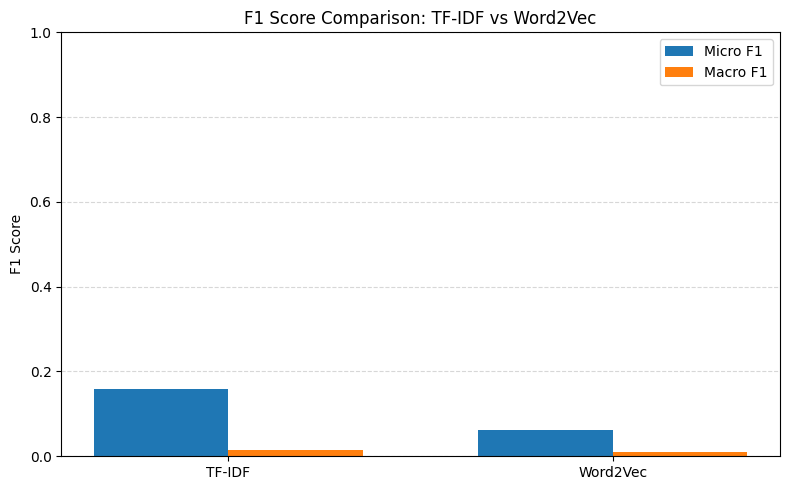

In [17]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Evaluate TF-IDF BiLSTM Model
# -----------------------------
model_tfidf.eval()
y_true_tfidf, y_pred_tfidf = [], []

with torch.no_grad():
    for inputs, targets in test_loader_tfidf:
        outputs = model_tfidf(inputs)
        preds = outputs.argmax(1)
        y_true_tfidf.extend(targets.numpy())
        y_pred_tfidf.extend(preds.numpy())

micro_f1_tfidf = f1_score(y_true_tfidf, y_pred_tfidf, average='micro')
macro_f1_tfidf = f1_score(y_true_tfidf, y_pred_tfidf, average='macro')

print(f"TF-IDF BiLSTM → Micro F1: {micro_f1_tfidf:.4f}, Macro F1: {macro_f1_tfidf:.4f}")

# -----------------------------
# Evaluate Word2Vec BiLSTM Model (Assumes you saved y_true/y_pred earlier)
# -----------------------------
micro_f1_w2v = f1_score(y_true, y_pred, average='micro')
macro_f1_w2v = f1_score(y_true, y_pred, average='macro')

print(f"Word2Vec BiLSTM → Micro F1: {micro_f1_w2v:.4f}, Macro F1: {macro_f1_w2v:.4f}")

# -----------------------------
# Visual Comparison Bar Chart
# -----------------------------
labels = ['TF-IDF', 'Word2Vec']
micro_f1s = [micro_f1_tfidf, micro_f1_w2v]
macro_f1s = [macro_f1_tfidf, macro_f1_w2v]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, micro_f1s, width, label='Micro F1')
plt.bar(x + width/2, macro_f1s, width, label='Macro F1')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison: TF-IDF vs Word2Vec")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming previous variables like `sequence_vectors`, `X_tfidf_scaled`, `full_data`, etc. are already defined

# Match overlapping valid indices
shared_indices = list(set(valid_indices_tfidf) & set(valid_indices))

# Create hybrid sequences
hybrid_sequences = []
hybrid_labels = []

for i in shared_indices:
    w2v_seq = sequence_vectors[i]
    tfidf_doc = X_tfidf_scaled[i]

    tfidf_lookup = dict(zip(tfidf_doc.indices, tfidf_doc.data))
    hybrid_seq = []

    for word in full_data["SYMPTOMS"].iloc[i]:
        if word in w2v_model.wv and word in tfidf.vocabulary_:
            w2v_vec = w2v_model.wv[word]
            tfidf_vec = np.zeros(len(tfidf.vocabulary_))
            tfidf_idx = tfidf.vocabulary_[word]
            tfidf_vec[tfidf_idx] = tfidf_lookup.get(tfidf_idx, 0.0)
            hybrid_vec = np.concatenate([w2v_vec, tfidf_vec])
            hybrid_seq.append(hybrid_vec)

    if hybrid_seq:
        hybrid_sequences.append(torch.tensor(hybrid_seq, dtype=torch.float32))
        hybrid_labels.append(labels_tensor[i].item())  # convert tensor to int

# Convert to DataFrame for filtering
hybrid_df = pd.DataFrame({
    "sequence": hybrid_sequences,
    "label": hybrid_labels
})

# Remove labels with only 1 sample
label_counts = hybrid_df["label"].value_counts()
valid_labels = label_counts[label_counts > 1].index
hybrid_df = hybrid_df[hybrid_df["label"].isin(valid_labels)]

# Final conversion
padded_hybrid = pad_sequence(hybrid_df["sequence"].tolist(), batch_first=True)
labels_hybrid = torch.tensor(hybrid_df["label"].tolist(), dtype=torch.long)

# Train/test split
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
    padded_hybrid, labels_hybrid, test_size=0.3, stratify=labels_hybrid, random_state=42
)

# DataLoaders
train_loader_hybrid = DataLoader(TensorDataset(X_train_hybrid, y_train_hybrid), batch_size=32, shuffle=True)
test_loader_hybrid = DataLoader(TensorDataset(X_test_hybrid, y_test_hybrid), batch_size=32)

# Output shape confirmation
padded_hybrid.shape, len(np.unique(hybrid_df["label"]))

(torch.Size([9244, 25, 789]), 47)

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import torch.optim as optim

# Step 1: Define hybrid model
input_dim_hybrid = w2v_model.vector_size + len(tfidf.vocabulary_)
model_hybrid = BiLSTMClassifier(input_dim=input_dim_hybrid, hidden_dim=64, output_dim=len(label_encoder.classes_))

# Step 2: Compute class weights based on only the classes in y_train_hybrid
unique_classes = np.unique(y_train_hybrid.numpy())
weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train_hybrid.numpy())
class_weights = torch.zeros(len(label_encoder.classes_), dtype=torch.float32)
class_weights[unique_classes] = torch.tensor(weights, dtype=torch.float32)

# Step 3: Define loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_hybrid.parameters(), lr=0.001)

# Step 4: Training loop
hybrid_train_losses = []
hybrid_train_accuracies = []

print("Training BiLSTM on HYBRID sequences...\n")
for epoch in range(30):
    model_hybrid.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader_hybrid:
        optimizer.zero_grad()
        outputs = model_hybrid(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    hybrid_train_losses.append(epoch_loss)
    hybrid_train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/30 | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

# Optional: Set model to eval mode after training
model_hybrid.eval()

Training BiLSTM on HYBRID sequences...

Epoch 1/30 | Loss: 3.8640 | Accuracy: 0.0618
Epoch 2/30 | Loss: 3.8384 | Accuracy: 0.0264
Epoch 3/30 | Loss: 3.8288 | Accuracy: 0.0476
Epoch 4/30 | Loss: 3.7849 | Accuracy: 0.0439
Epoch 5/30 | Loss: 3.6406 | Accuracy: 0.0691
Epoch 6/30 | Loss: 3.6159 | Accuracy: 0.0726
Epoch 7/30 | Loss: 3.5837 | Accuracy: 0.0611
Epoch 8/30 | Loss: 3.5711 | Accuracy: 0.0476
Epoch 9/30 | Loss: 3.5682 | Accuracy: 0.0493
Epoch 10/30 | Loss: 3.5435 | Accuracy: 0.0541
Epoch 11/30 | Loss: 3.5305 | Accuracy: 0.0563
Epoch 12/30 | Loss: 3.5206 | Accuracy: 0.0379
Epoch 13/30 | Loss: 3.5171 | Accuracy: 0.0538
Epoch 14/30 | Loss: 3.4804 | Accuracy: 0.0496
Epoch 15/30 | Loss: 3.4690 | Accuracy: 0.0450
Epoch 16/30 | Loss: 3.4526 | Accuracy: 0.0473
Epoch 17/30 | Loss: 3.4308 | Accuracy: 0.0522
Epoch 18/30 | Loss: 3.4053 | Accuracy: 0.0538
Epoch 19/30 | Loss: 3.3949 | Accuracy: 0.0518
Epoch 20/30 | Loss: 3.3630 | Accuracy: 0.0533
Epoch 21/30 | Loss: 3.3626 | Accuracy: 0.0505
Epo

BiLSTMClassifier(
  (lstm): LSTM(789, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=49, bias=True)
)

In [22]:
from sklearn.metrics import f1_score

# Evaluate model
model_hybrid.eval()
y_true_hybrid, y_pred_hybrid = [], []

with torch.no_grad():
    for inputs, targets in test_loader_hybrid:
        outputs = model_hybrid(inputs)
        preds = outputs.argmax(1)
        y_true_hybrid.extend(targets.numpy())
        y_pred_hybrid.extend(preds.numpy())

# F1 Scores
micro_f1_hybrid = f1_score(y_true_hybrid, y_pred_hybrid, average='micro')
macro_f1_hybrid = f1_score(y_true_hybrid, y_pred_hybrid, average='macro')
print(f"Hybrid BiLSTM → Micro F1: {micro_f1_hybrid:.4f}, Macro F1: {macro_f1_hybrid:.4f}")

Hybrid BiLSTM → Micro F1: 0.0364, Macro F1: 0.0223


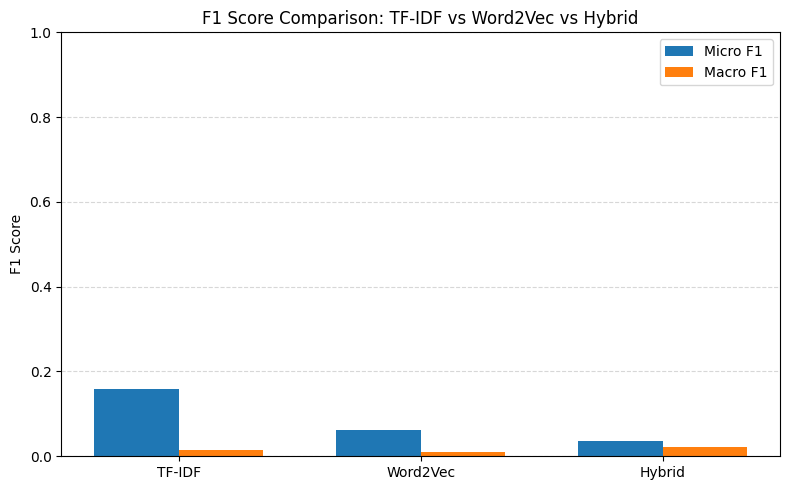

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Bar chart comparison
labels = ['TF-IDF', 'Word2Vec', 'Hybrid']
micro_f1s = [micro_f1_tfidf, micro_f1_w2v, micro_f1_hybrid]
macro_f1s = [macro_f1_tfidf, macro_f1_w2v, macro_f1_hybrid]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, micro_f1s, width, label='Micro F1')
plt.bar(x + width/2, macro_f1s, width, label='Macro F1')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison: TF-IDF vs Word2Vec vs Hybrid")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import f1_score, classification_report

# Evaluate Hybrid Model
y_true_hybrid, y_pred_hybrid = [], []

with torch.no_grad():
    for inputs, targets in test_loader_hybrid:
        outputs = model_hybrid(inputs)
        preds = outputs.argmax(1)
        y_true_hybrid.extend(targets.numpy())
        y_pred_hybrid.extend(preds.numpy())

# F1 Scores
micro_f1_hybrid = f1_score(y_true_hybrid, y_pred_hybrid, average='micro')
macro_f1_hybrid = f1_score(y_true_hybrid, y_pred_hybrid, average='macro')

print(f"Hybrid BiLSTM → Micro F1: {micro_f1_hybrid:.4f}, Macro F1: {macro_f1_hybrid:.4f}")

# Optional: Classification report
report = classification_report(y_true_hybrid, y_pred_hybrid, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("hybrid_classification_report.csv")
print(report_df.head())

Hybrid BiLSTM → Micro F1: 0.0364, Macro F1: 0.0223
   precision    recall  f1-score  support
0   0.000000  0.000000   0.00000    224.0
1   0.000000  0.000000   0.00000    245.0
2   0.000000  0.000000   0.00000    356.0
3   0.090909  0.006579   0.01227    152.0
4   0.000000  0.000000   0.00000    261.0


C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

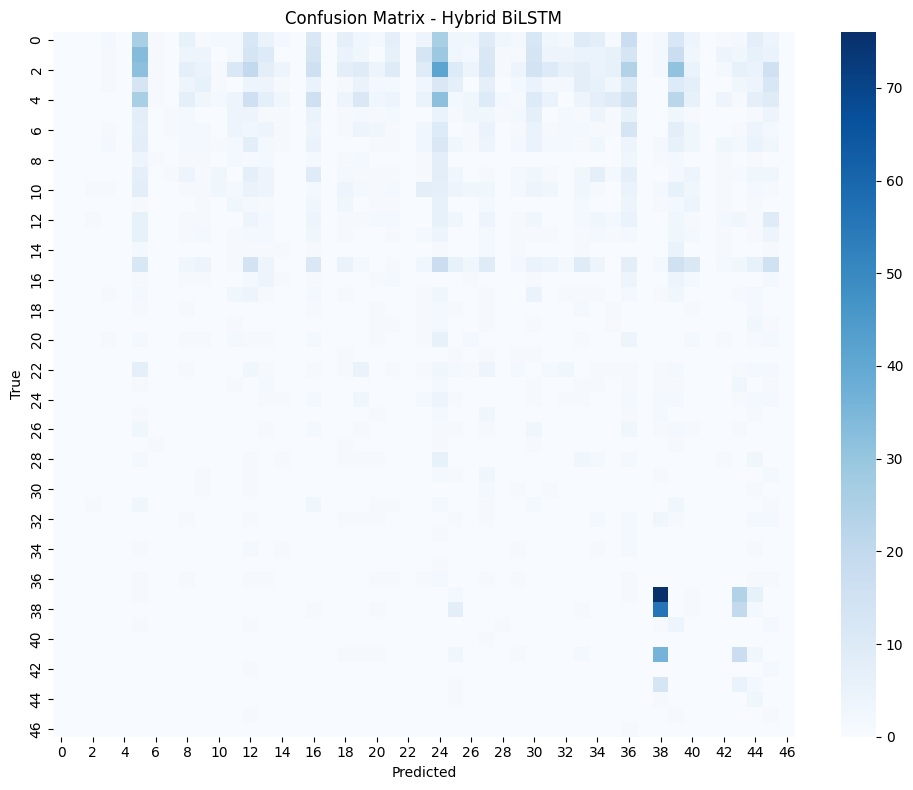

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_hybrid, y_pred_hybrid)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, cmap="Blues", cbar=True)
plt.title("Confusion Matrix - Hybrid BiLSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

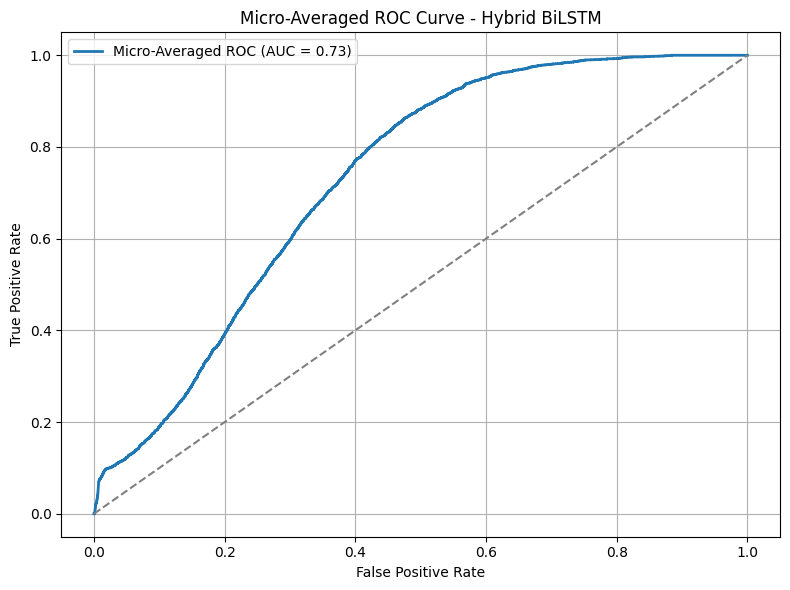

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# One-hot encode y_true_hybrid
y_true_bin = np.zeros((len(y_true_hybrid), len(label_encoder.classes_)))
y_true_bin[np.arange(len(y_true_hybrid)), y_true_hybrid] = 1

# Get prediction probabilities
y_proba_hybrid = []
model_hybrid.eval()
with torch.no_grad():
    for inputs, _ in test_loader_hybrid:
        outputs = model_hybrid(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_proba_hybrid.extend(probs.numpy())

y_proba_hybrid = np.array(y_proba_hybrid)

# Micro-average ROC curve
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_proba_hybrid.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Micro-Averaged ROC (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Micro-Averaged ROC Curve - Hybrid BiLSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()